# Importing dependancies

In [6]:
import gym

import numpy as np
import random
from collections import namedtuple, deque
from more_itertools import chunked

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model definition

We can use the state variables (position of cart, angle of pole)

In [8]:
class ActorCritic(nn.Module):

    def __init__(self, output_size):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.LazyLinear(64) 
        self.fc2 = nn.LazyLinear(64)
        self.a1 = nn.LazyLinear(32) 
        self.a2 = nn.LazyLinear(output_size) 
        self.c1 = nn.LazyLinear(32) 
        self.c2 = nn.LazyLinear(1) 

        self.act = nn.PReLU()
        self.softmax = nn.Softmax()

    def forward(self, input):
        x = self.act(self.fc1(input))
        x = self.act(self.fc2(x))
        a_output = self.act(self.a1(x))
        a_output = self.softmax(self.a2(x))
        c_output = self.act(self.c1(x))
        c_output = self.c2(x)
        return a_output, c_output

# Creating the agent

In [9]:
class ActorCriticAgent:
    def __init__(self, env):

        self.action_size = env.action_space.n # output size
        
        self.model = ActorCritic(self.action_size).to(device)

        self.critic_loss = nn.SmoothL1Loss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)

        self.num_epochs = 500
        self.gamma = 0.99

        self.batch_size = 64

    def act(self, state):
        action_prob, critique = self.model(state)
        m = Categorical(action_prob)
        action = m.sample()
        return action.item(), critique, m.log_prob(action)
    
    def act_ideal(self, state):
        actions, critique = self.model(state)
        return actions.max(1)[1].item()
    
    def train_step(self, log_probs, critiques, rewards):
        
        discount_reward_sum = 0
        returns = []

        for reward in rewards[::-1]:
            discount_reward_sum = reward + self.gamma * discount_reward_sum
            returns.insert(0, discount_reward_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + np.finfo(np.float32).eps.item())
        returns = returns.tolist()

        policy_losses = []
        critic_losses = []

        for log_prob, critique, r in zip(log_probs, critiques, returns):
            advantage = r - critique

            policy_losses.append(-log_prob * advantage)
            critic_losses.append(self.critic_loss(critique, torch.Tensor([r]).to(device)))


        loss = torch.stack(policy_losses).sum() + torch.stack(critic_losses).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
    def train(self, env, print_epochs=False):

        scores = []

        for epoch in range(self.num_epochs):
            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(curr_state).to(device)
            score = 0

            log_probs = []
            critiques = []
            rewards = []
            
            while not done:

                action, critique, log_prob = self.act(curr_state.unsqueeze(0))
                curr_state, reward, done, _ = env.step(action)
                curr_state = torch.Tensor(curr_state).to(device)

                log_probs.append(log_prob)
                critiques.append(critique)
                rewards.append(reward)

                score += reward

            
            self.train_step(log_probs, critiques, rewards)

            scores.append(score)

            if print_epochs:
                print("Epoch: " + str(epoch + 1) + ". Score is: " + str(score))
            
        return scores


# Training the agent

C:\Users\Sean Jan's PC\AppData\Local\Temp\ipykernel_12268\171430093.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a_output = self.softmax(self.a2(x))


Epoch: 1. Score is: -200.0
Epoch: 2. Score is: -200.0
Epoch: 3. Score is: -200.0
Epoch: 4. Score is: -200.0
Epoch: 5. Score is: -200.0
Epoch: 6. Score is: -200.0
Epoch: 7. Score is: -200.0
Epoch: 8. Score is: -200.0
Epoch: 9. Score is: -200.0
Epoch: 10. Score is: -200.0
Epoch: 11. Score is: -200.0
Epoch: 12. Score is: -200.0
Epoch: 13. Score is: -200.0
Epoch: 14. Score is: -200.0
Epoch: 15. Score is: -200.0
Epoch: 16. Score is: -200.0
Epoch: 17. Score is: -200.0
Epoch: 18. Score is: -200.0
Epoch: 19. Score is: -200.0
Epoch: 20. Score is: -200.0
Epoch: 21. Score is: -200.0
Epoch: 22. Score is: -200.0
Epoch: 23. Score is: -200.0
Epoch: 24. Score is: -200.0
Epoch: 25. Score is: -200.0
Epoch: 26. Score is: -200.0
Epoch: 27. Score is: -200.0
Epoch: 28. Score is: -200.0
Epoch: 29. Score is: -200.0
Epoch: 30. Score is: -200.0
Epoch: 31. Score is: -200.0
Epoch: 32. Score is: -200.0
Epoch: 33. Score is: -200.0
Epoch: 34. Score is: -200.0
Epoch: 35. Score is: -200.0
Epoch: 36. Score is: -200.0
E

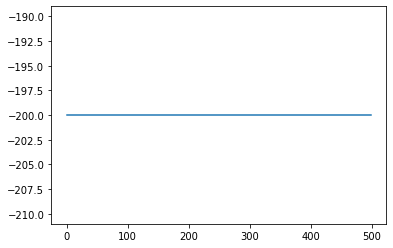

In [10]:
env = gym.make("MountainCar-v0")
torch.autograd.set_detect_anomaly(False)
agent = ActorCriticAgent(env)
env.reset()
scores = agent.train(env, print_epochs=True)
plt.plot(scores)
plt.show()

In [11]:
np.save('mountaincar_ac_scores.npy', scores)